In [2]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os.path 
import hddm
#import statsmodels.api as sm
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from patsy import center
%matplotlib inline 
cmap = sns.color_palette("hls", 8)
sns.set_palette(cmap)
sns.set_style("white")
import kabuki

# ======== #
# in HDDM 
# ======== #
# a - describes the distance between the decision boundaries
# t - describes all the non-decision time parameters (action, perception etc)
# z - bias that describes the starting point
# v - drift-rate
# dc, sv, st, sz - drift criterion, inter-trial variability

In [2]:
# test parallel
import ipyparallel as ipp
c = ipp.Client()
c.ids
c[:].apply_sync(lambda : "test")

['test', 'test', 'test', 'test']

In [ ]:
def run_model(id):
    import hddm
    import os.path
    
    #exp1, 2a, 2b
    data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv') 
    data.rename(columns = {'Unnamed: 0': 'id', 'correct':'response'}, inplace = True)
    
    reg = ['v ~ 1 + SC_c + SC_squared'] #7
   
    os.chdir(u'/home/nseijde1')
    m = hddm.HDDMRegressor(data, reg, depends_on={'a':'SpAc'},bias=True,include={'z'}, p_outlier=0.05)
    m.find_starting_values()
    m.sample(5000, burn=200, thin=2, dbname='m7traces%i.db'%id, db='pickle')
    return m

os.chdir(u'/home/nseijde1')

jobs = c[:].map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

combined_model = kabuki.utils.concat_models(models)
os.chdir('/home/Projects/scenestats/exp1/m7')  
combined_model.save('m7')
combined_model.print_stats()
combined_model.plot_posteriors(save=True)

# compute gelman rubic
gr = hddm.analyze.gelman_rubin(models)
text_file = open('gelman_rubic.txt', 'w')
for p in gr.items():
     text_file.write("%s:%s\n" % p)
text_file.close()

In [9]:
# Load best model
os.chdir('/home/Projects/scenestats/exp1/all/m7')
model = hddm.load('m7')
print model.dic
#model.gen_stats('stats.txt')

-14592.692809


[0.0, 0.0]


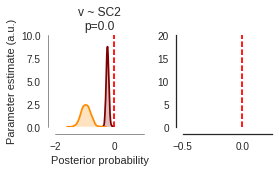

In [10]:
fig_dir = u'/home/Projects/scenestats/exp1/all/m7'
params_of_interest = ['v_SC_c', 'v_SC_squared']
titles = ['v ~ SC', 'v ~ SC2' ]

traces = []
for p in range(len(params_of_interest)):
    traces.append(model.nodes_db.node[params_of_interest[p]].trace.gettrace())

stats = []
for p in range(len(params_of_interest)):
    stat = min(np.mean(traces[p] > 0), np.mean(traces[p] < 0))
    stats.append(min(stat, 1-stat))
#stats = np.array(stats)    

print stats
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4,2.5))

ax_nr = 0
pl = 0
cc=['maroon','darkorange']
for p in range(len(params_of_interest)):
    data = [traces[p]]
    ax = axes[ax_nr]
    for d, label, c in zip(data, ['1',], ['black']):
        sns.kdeplot(d, vertical=False, shade=True, color=cc[pl], ax=ax)
        ax.set_xlabel('Posterior probability')
        ax.set_title('{}\np={}'.format(titles[pl], round(stats[p],3)))
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
            ax.tick_params(width=0.5)          
        pl+=1
        if pl == 2:
            ax_nr+=1
        
sns.despine(offset=7, trim=False)
axes[0].set_ylabel('Parameter estimate (a.u.)')
axes[0].axvline(x=0, color='r', linestyle='--')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[0].set_ylim(0,10)
axes[0].set_xlim(-2,1)
axes[1].set_ylim(0,20)
axes[1].set_xlim(-0.5,0.25)

plt.tight_layout()
fig.savefig(os.path.join(fig_dir, 'posteriorsZ.pdf'))